This notebook demonstrates use of our linear approximation for a multiplicative functional perturbation 

In [1]:
from autograd import numpy as np
from autograd import scipy as sp

from numpy.polynomial.hermite import hermgauss

np.random.seed(453453)

import paragami

# BNP sensitivity libraries
import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
from bnpgmm_runjingdev import hessian_lib
import bnpgmm_runjingdev.gmm_cavi_lib as cavi_lib
import bnpgmm_runjingdev.gmm_preconditioner_lib as preconditioner_lib
import bnpgmm_runjingdev.functional_sensitivity_lib as fun_sens_lib 
from bnpgmm_runjingdev import utils_lib

from bnpmodeling_runjingdev import modeling_lib 
from bnpmodeling_runjingdev import optimization_lib 
from bnpmodeling_runjingdev import cluster_quantities_lib as cluster_lib


import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA

from copy import deepcopy

import vittles
from tqdm import tqdm

import json 

/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


In [2]:
# colors for plotting
import matplotlib.cm as cm

cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(12)]
colors2 = [cmap(k * 25) for k in range(12)]

# Load data

We load and plot the iris dataset

In [3]:
# load iris data
dataset_name = 'iris'
features, iris_species = utils_lib.load_data()
dim = features.shape[1]
n_obs = len(iris_species)    

Text(0, 0.5, 'PC2')

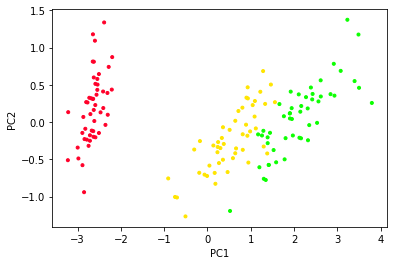

In [4]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Load model

### Get prior 

In [5]:
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)

In [6]:
print(prior_params_dict)

{'alpha': array([3.]), 'prior_centroid_mean': array([0.]), 'prior_lambda': array([1.]), 'prior_wishart_df': array([10.]), 'prior_wishart_rate': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])}


In [7]:
# DP prior parameter 
prior_params_dict['alpha'] = 12

### Variational parameters

In [8]:
k_approx = 30

In [9]:
# Gauss-Hermite points
gh_deg = 20
gh_loc, gh_weights = hermgauss(gh_deg)


In [10]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [11]:
# the objective 
gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

2009.3998815516827

# Optimize

### Kmeans

In [12]:
n_kmeans_init = 50
init_vb_free_params, init_vb_params_dict, init_ez = \
    utils_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init, 
                                                seed = 32423)

### Run CAVI

In [13]:
vb_opt_dict, e_z_opt = cavi_lib.run_cavi(features, vb_params_dict,
                                            vb_params_paragami, prior_params_dict,
                                            gh_loc, gh_weights,
                                            debug = False, 
                                            x_tol = 1E-3)

done. num iterations = 112
stick_time: 0.632sec
cluster_time: 0.053sec
e_z_time: 0.151sec
**TOTAL time: 1.853sec**


In [14]:
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

In [15]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_params_dict['cluster_params']['cluster_info']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])


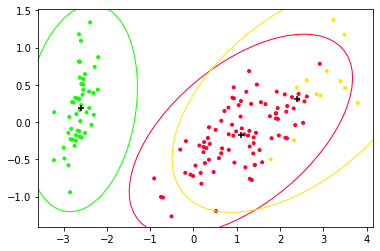

In [16]:
# results
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)

# Define a perturbation in the logit v space.

In [17]:
def log_phi(logit_v):
    return(sp.special.expit(logit_v))

def phi(logit_v):
    return np.exp(log_phi(logit_v))


In [18]:
logit_v_grid = np.linspace(-8, 8, 200)

v_grid = np.exp(logit_v_grid) / (1 + np.exp(logit_v_grid))

print('phi max: ', np.max(phi(logit_v_grid)))
log_phi_max = np.max(np.abs(np.log(phi(logit_v_grid))))
print('log phi max: ', log_phi_max)

def rescaled_log_phi(logit_v):
    return 10 * log_phi(logit_v) / log_phi_max


phi max:  2.717370405124736
log phi max:  0.9996646498695336


In [19]:
prior_perturbation = fun_sens_lib.PriorPerturbation(
                                alpha0 = prior_params_dict['alpha'],
                                log_phi = rescaled_log_phi, 
                                logit_v_ub=8, logit_v_lb = -8)

print(
    prior_perturbation.log_norm_p0,
    prior_perturbation.log_norm_pc,
    prior_perturbation.log_norm_p0_logit,
    prior_perturbation.log_norm_pc_logit)

-2.4849066497879995 1.1634968823127927 -2.4889315240780148 1.1662640532746475


Text(0.5, 1.0, 'Priors in logit space')

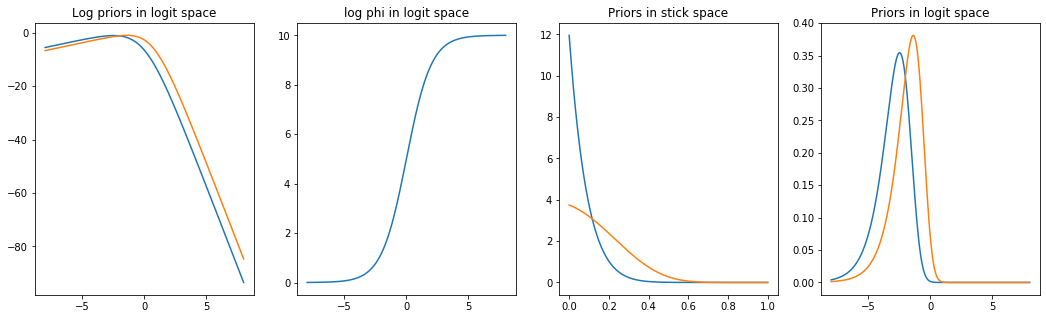

In [20]:
prior_perturbation.set_epsilon(1.0)

plt.figure(1, figsize=(18, 5))

plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, prior_perturbation.log_phi(logit_v_grid))
plt.title('log phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


# Define prior perturbation

In [21]:
# we will use this for the sensitivity class
get_epsilon_vb_loss = paragami.FlattenFunctionInput(
    lambda params, epsilon: fun_sens_lib.get_perturbed_kl(
                                                        features, 
                                                        params,
                                                        epsilon,
                                                        rescaled_log_phi,
                                                        prior_params_dict, 
                                                        gh_loc, gh_weights),
    argnums=0, patterns=vb_params_paragami, free=True)
    
hyper_par_objective_fun = paragami.FlattenFunctionInput(
    lambda params, epsilon: fun_sens_lib.get_e_log_perturbation(
                                                                rescaled_log_phi, 
                                                                params,
                                                                epsilon,
                                                                gh_loc, gh_weights),
    argnums=0, patterns=vb_params_paragami, free=True)

In [22]:
epsilon0 = np.array([0.])

In [23]:
# get preconditioner 
k_large = 5
which_k = np.argsort(-e_z_opt.mean(0))[0:k_large]

sub_block_hess, indx = hessian_lib.get_large_clusters_hessian(features, which_k, vb_opt, vb_params_paragami, 
                                                                  prior_params_dict, gh_loc, gh_weights)

est_lambda_max = np.abs(sub_block_hess).sum(1).max()
nystrom_precond = preconditioner_lib.get_nystrom_woodbury_precon(sub_block_hess, indx, est_lambda_max)


In [24]:
import autograd
import time

In [25]:
obj_fun_hvp = autograd.hessian_vector_product(get_epsilon_vb_loss, argnum = 0)

hess_solver = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_opt, epsilon0, x), 
                                                        dim = len(vb_opt), 
                                                        cg_opts={'M':nystrom_precond})

    
t0 = time.time()
epsilon_sens = \
    vittles.HyperparameterSensitivityLinearApproximation(
        objective_fun = get_epsilon_vb_loss, 
        opt_par_value = vb_opt, 
        hyper_par_value = epsilon0, 
        hess_solver = hess_solver, 
        hyper_par_objective_fun = hyper_par_objective_fun)

print('derivative time: {}sec'.format(np.round(time.time() - t0, 3)))

derivative time: 7.055sec


## Fit with perturbation

In [26]:
epsilon = 1.0 
print('Epsilon: ', epsilon)

vb_pert_pred = epsilon_sens.predict_opt_par_from_hyper_par(epsilon)

print('Predicted differences: ', np.linalg.norm(vb_pert_pred - vb_opt))

Epsilon:  1.0
Predicted differences:  4.042864862598715


In [27]:
vb_pert_pred_dict = vb_params_paragami.fold(vb_pert_pred, free = True)
e_z_pert_pred = gmm_lib.get_optimal_z_from_vb_params_dict(
    features, vb_pert_pred_dict, gh_loc, gh_weights)

In [28]:
# get flattened perturbed KL
def get_loss_for_epsilon(epsilon):
    get_perturbed_vb_loss_flattened = paragami.FlattenFunctionInput(
        lambda params: 
            fun_sens_lib.get_perturbed_kl(
                features, params, epsilon, rescaled_log_phi, 
                 prior_params_dict, gh_loc, gh_weights),
        argnums=0,
        patterns=vb_params_paragami,
        free=True)
    return get_perturbed_vb_loss_flattened

get_perturbed_vb_loss_flattened = get_loss_for_epsilon(epsilon)

In [29]:
new_init_dict = deepcopy(vb_opt_dict)
new_init_free = vb_params_paragami.flatten(new_init_dict, free = True)

In [30]:
vb_pert_dict, e_z_pert = cavi_lib.run_cavi(features, deepcopy(new_init_dict),
                                        vb_params_paragami, prior_params_dict,
                                        gh_loc, gh_weights,
                                        log_phi = rescaled_log_phi, epsilon = epsilon, 
                                       debug = False)

vb_pert_opt = vb_params_paragami.flatten(vb_pert_dict, free = True)

done. num iterations = 101
stick_time: 2.413sec
cluster_time: 0.048sec
e_z_time: 0.136sec
**TOTAL time: 3.528sec**


In [31]:
vb_pert_opt_dict = vb_params_paragami.fold(vb_pert_opt, free = True)
e_z_pert_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_pert_opt_dict, gh_loc, gh_weights)

Epsilon: 1.0


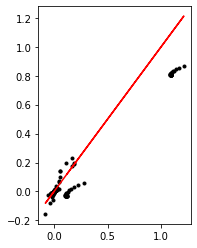

In [32]:
print('Epsilon:', epsilon)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(vb_pert_opt - vb_opt, vb_pert_pred - vb_opt, 'k.')
plt.plot(vb_pert_opt - vb_opt, vb_pert_opt - vb_opt, 'r')


In [33]:
print('original expected number of clusters: ',
    cluster_lib.get_e_number_clusters_from_logit_sticks(vb_opt_dict['stick_params']['stick_propn_mean'], 
                                                        vb_opt_dict['stick_params']['stick_propn_info'], 
                                                        n_obs = 150, 
                                                        n_samples = 10000))

print('perturbed expected number of clusters: ',
    cluster_lib.get_e_number_clusters_from_logit_sticks(vb_pert_opt_dict['stick_params']['stick_propn_mean'], 
                                                        vb_pert_opt_dict['stick_params']['stick_propn_info'], 
                                                        n_obs = 150, 
                                                        n_samples = 10000))

print('predicted expected number of clusters: ',
    cluster_lib.get_e_number_clusters_from_logit_sticks(vb_pert_pred_dict['stick_params']['stick_propn_mean'], 
                                                        vb_pert_pred_dict['stick_params']['stick_propn_info'], 
                                                        n_obs = 150, 
                                                        n_samples = 10000))


      

original expected number of clusters:  11.48696832835835
perturbed expected number of clusters:  9.804688704753342
predicted expected number of clusters:  9.826841529326256


# Predict for a range of perturbations

In [34]:
# The range of epsilons we shall consider
epsilon_vec = np.linspace(0, 1, 12) ** 2 # Square to get more points close to 0
print(epsilon_vec)

[0.         0.00826446 0.03305785 0.07438017 0.1322314  0.20661157
 0.29752066 0.40495868 0.52892562 0.66942149 0.82644628 1.        ]


In [35]:
def refit_with_epsilon(epsilon, new_init_dict):
    # sets new epsilon, returns new vb optimum

    vb_pert_dict, e_z_pert = cavi_lib.run_cavi(features, deepcopy(new_init_dict),
                                        vb_params_paragami, prior_params_dict,
                                        gh_loc, gh_weights,
                                        log_phi = rescaled_log_phi, epsilon = epsilon, 
                                       debug = False)
    
    return vb_params_paragami.flatten(vb_pert_dict, free = True)

In [36]:
best_param_phi_array = []
best_param_phi_pred_array = []

In [37]:
vb_pert_opt_array = []
vb_pert_pred_array = []


for i in range(len(epsilon_vec)): 
    epsilon = epsilon_vec[i]
    print('\n\nEpsilon: ', epsilon)
    
    # get linear predictions
    vb_pert_pred = \
        epsilon_sens.predict_opt_par_from_hyper_par(epsilon)

    print('Predicted differences: ', np.linalg.norm(vb_pert_pred - vb_opt))
    
    # Then fit with the perturbation.
    vb_pert_opt = refit_with_epsilon(epsilon, new_init_dict)
    
    print('Done. ')

    print('Predicted differences: ', np.linalg.norm(vb_pert_pred - vb_opt))
    print('Actual differences: (This is nonzero if phi did anything):',
          np.linalg.norm(vb_pert_opt - vb_opt))
    
    # save results: 
    vb_pert_opt_array.append(vb_pert_opt)
    vb_pert_pred_array.append(vb_pert_pred)
    




Epsilon:  0.0
Predicted differences:  0.0
done. num iterations = 3
stick_time: 0.146sec
cluster_time: 0.004sec
e_z_time: 0.007sec
**TOTAL time: 0.195sec**
Done. 
Predicted differences:  0.0
Actual differences: (This is nonzero if phi did anything): 0.008007478545388191


Epsilon:  0.008264462809917356
Predicted differences:  0.033412106302468804
done. num iterations = 10
stick_time: 0.246sec
cluster_time: 0.005sec
e_z_time: 0.016sec
**TOTAL time: 0.364sec**
Done. 
Predicted differences:  0.033412106302468804
Actual differences: (This is nonzero if phi did anything): 0.024253739256433187


Epsilon:  0.03305785123966942
Predicted differences:  0.13364842520987472
done. num iterations = 18
stick_time: 0.46sec
cluster_time: 0.009sec
e_z_time: 0.026sec
**TOTAL time: 0.667sec**
Done. 
Predicted differences:  0.13364842520987472
Actual differences: (This is nonzero if phi did anything): 0.10908084949443404


Epsilon:  0.07438016528925619
Predicted differences:  0.3007089567222186
done. num 

# Lets look at the expected number of clusters

### Number of in sample clusters

In [38]:
threshold = 0

lr_e_num_clusters_vec = np.zeros(len(epsilon_vec))
refit_e_num_clusters_vec = np.zeros(len(epsilon_vec))

for i in tqdm(range(len(epsilon_vec))): 
    # number of clusters as predicted by linear response
    lr_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(
        features, vb_params_paragami, 
        vb_pert_pred_array[i],
        gh_loc, gh_weights,
        threshold = threshold,
        n_samples = 100000)
    
    lr_e_num_clusters_vec[i] = lr_e_num_clusters
    
    # number of clusters after refitting 
    refit_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(
        features, vb_params_paragami, 
        vb_pert_opt_array[i],
        gh_loc, gh_weights,
        threshold = threshold,
        n_samples = 100000)
    
    refit_e_num_clusters_vec[i] = refit_e_num_clusters
    


100%|██████████| 12/12 [00:27<00:00,  2.33s/it]


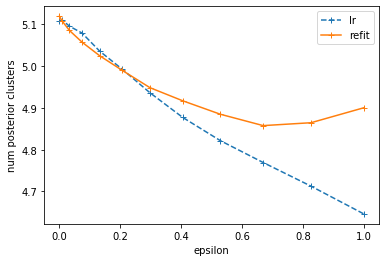

In [39]:
plt.plot(epsilon_vec, lr_e_num_clusters_vec, '+--')
plt.plot(epsilon_vec, refit_e_num_clusters_vec, '+-')

plt.xlabel('epsilon')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))


### Number of predicted clusters

In [40]:
threshold = 0

lr_e_num_pred_clusters_vec = np.zeros(len(epsilon_vec))
refit_e_num_pred_clusters_vec = np.zeros(len(epsilon_vec))

for i in tqdm(range(len(epsilon_vec))): 
     # number of clusters as predicted by linear response
    lr_e_num_pred_clusters = gmm_lib.get_e_num_pred_clusters_from_vb_free_params(
        vb_params_paragami, 
        vb_pert_pred_array[i],
        n_obs = np.shape(features)[0], 
        threshold = threshold,
        n_samples = 100000)
    
    lr_e_num_pred_clusters_vec[i] = lr_e_num_pred_clusters
    
    # number of clusters after refitting 
    refit_e_num_pred_clusters = gmm_lib.get_e_num_pred_clusters_from_vb_free_params(
        vb_params_paragami, 
        vb_pert_opt_array[i],
        n_obs = np.shape(features)[0], 
        threshold = threshold,
        n_samples = 100000)
    
    refit_e_num_pred_clusters_vec[i] = refit_e_num_pred_clusters
    


100%|██████████| 12/12 [00:05<00:00,  2.04it/s]


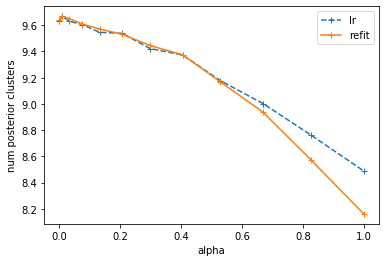

In [41]:
plt.plot(epsilon_vec, lr_e_num_pred_clusters_vec, '+--')
plt.plot(epsilon_vec, refit_e_num_pred_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))